# PA005: High Value Customer Identification

## <font color='red'> Ciclo 00 - Planejamento - Método IOT </font>

## <font color='red'> Ciclo 01 - Métricas de Validação de Clusters </font>

1. Feature Engineering
    - Recência
    - Frequência
    - Monetização
    
    
2. Métricas de validação de Clustering
    - WSS ( Within-Cluster Sum of Square )  
    - SS ( Silhouette Score )
    
    
3. Cluster Analysis
    - Plot 3D
    - Cluster Profile

## <font color='red'> Ciclo 02 - Silhouette Analysis </font>

1. Feature Engineering
    - Average Ticket
    
    
2. Análise de Silhouette
    - Silhouette Analysis  
    
    
3. Cluster Visualization
    - t-SNE
    
    
4. Cluster Análise de Perfil
    - Descrição dos centróides dos cluster

## <font color='red'> Ciclo 03 - </font>

1. Análise Descritiva
    - Atributos numéricos
    - Atributos categóricos
    
    
2. Feature Engineering
    - Average Ticket
    - Average Recency
    
    
2. Data preparation
    - Standard Scaler
    - MinMax Scaler
    
    
3. Métricas de validação de Clustering
    - DB Index
    - Dunn Index
    - GS ( Gap Statistic) 
    - DB Index ( Davies Bouldin Index )
    - CH Index
    - Gap Statistic
    
    
4. Análise de Silhouette
    - Silhouette Analysis  
    
    
5. Cluster Visualization
    - t-SNE

# Planejamento da Solução ( IOT )

## Input - Entrada

### O problema de negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0. Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from plotly  import express       as px

from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import manifold      as mf
from sklearn import preprocessing as pp

from matplotlib import pyplot as plt
from matplotlib import cm     as cm

from yellowbrick import cluster   as yc

from IPython.core.display import HTML

/Users/meigarom.lopes/.pyenv/versions/3.8.0/envs/pa005insidersclustering/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 0.2. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Load dataset

In [3]:
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='unicode_escape' )

# <font color='red'> 1.0. Descrição dos dados </font>

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country', 'unnamed']
df1.columns = new_cols

df1 = df1.drop( 'unnamed', axis=1 )

## 1.2. Data dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
# remove na
df1 = df1.dropna( subset=['description', 'customer_id'] )

print( 'Removed data: {:.2f}%'.format( 1-( df1.shape[0]/df_raw.shape[0] ) ) )

Removed data: 0.25%


## 1.6. Change Dtypes

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [11]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics

### 1.7.1. Numerical Attributes

### 1.7.2. Categorical Attributes

# <font color='red'> 2.0. Feature Engineering </font>

In [13]:
df2 = df1.copy()

## 2.1. Create new features

In [14]:
# data reference
df_ref = df2.drop( ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

# Gross Revenue ( Faturamento )
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Recency
df_recency = df2[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, how='left', on='customer_id' )

# Frequency
df_frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index()
df_ref = pd.merge( df_ref, df_frequency, how='left', on='customer_id' )

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, how='left', on='customer_id' )

# Average Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'} )
df_avg_ticket['avg_ticket'] = np.round( df_avg_ticket['avg_ticket'], 2 )
df_ref = pd.merge( df_ref, df_avg_ticket, how='left', on='customer_id' )

# <font color='red'> 3.0. Filtragem de Variáveis </font>

In [15]:
df3 = df_ref.copy()

# <font color='red'> 4.0. EDA ( Análise Exploratória de Dados ) </font>

In [16]:
df4 = df3.copy()

# <font color='red'> 5.0. Data Preparation </font>

In [17]:
df5 = df4.copy()

# <font color='red'> 6.0. Feature Selection </font>

In [18]:
df6 = df5.copy()

# <font color='red'> 7.0. Hyperparamter fine-tunning </font>

In [19]:
X = df6.drop( columns=['customer_id'] ).copy()
X.head()

,recency_days,invoice_no,gross_revenue,avg_ticket
0,302,35,5288.63,16.95
1,31,18,3079.10,15.71
2,2,18,7187.34,28.63
3,95,5,948.25,33.87
4,330,6,635.10,105.85


### 7.1. Clustering Validation Metrics

In [20]:
clusters = [2, 3, 4, 5, 6, 7]

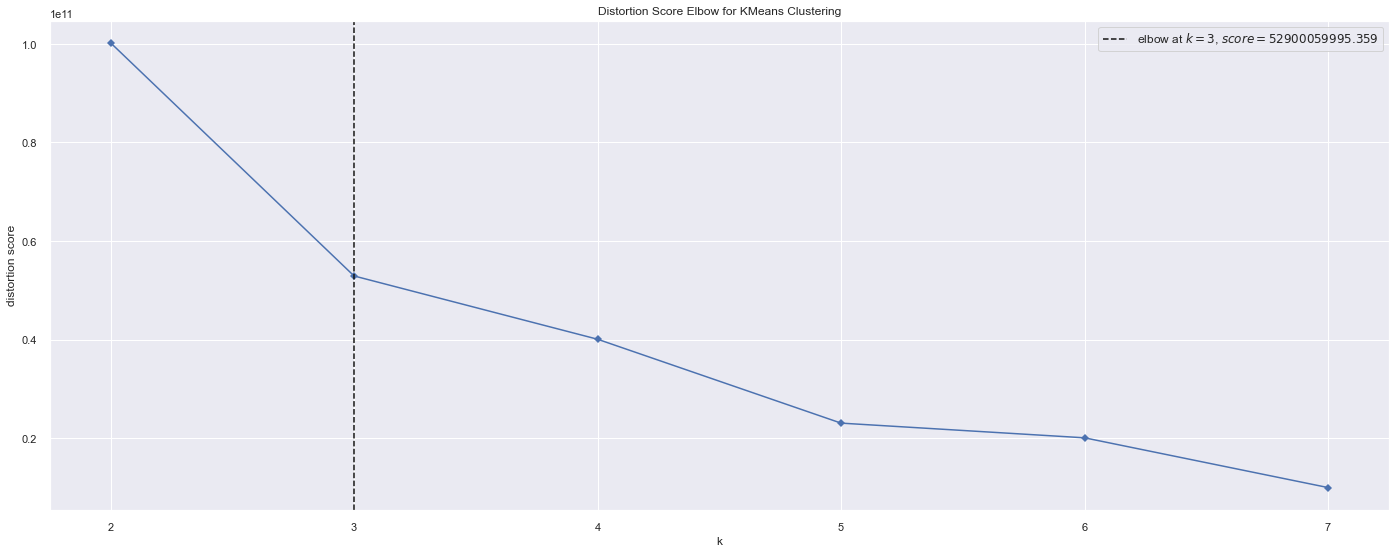

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
kmeans = yc.KElbowVisualizer( c.KMeans( init='random', n_init=10, 
                                     max_iter=300, random_state=42 ),
                           k=clusters,
                           timings=False )
kmeans.fit( X )
kmeans.show()

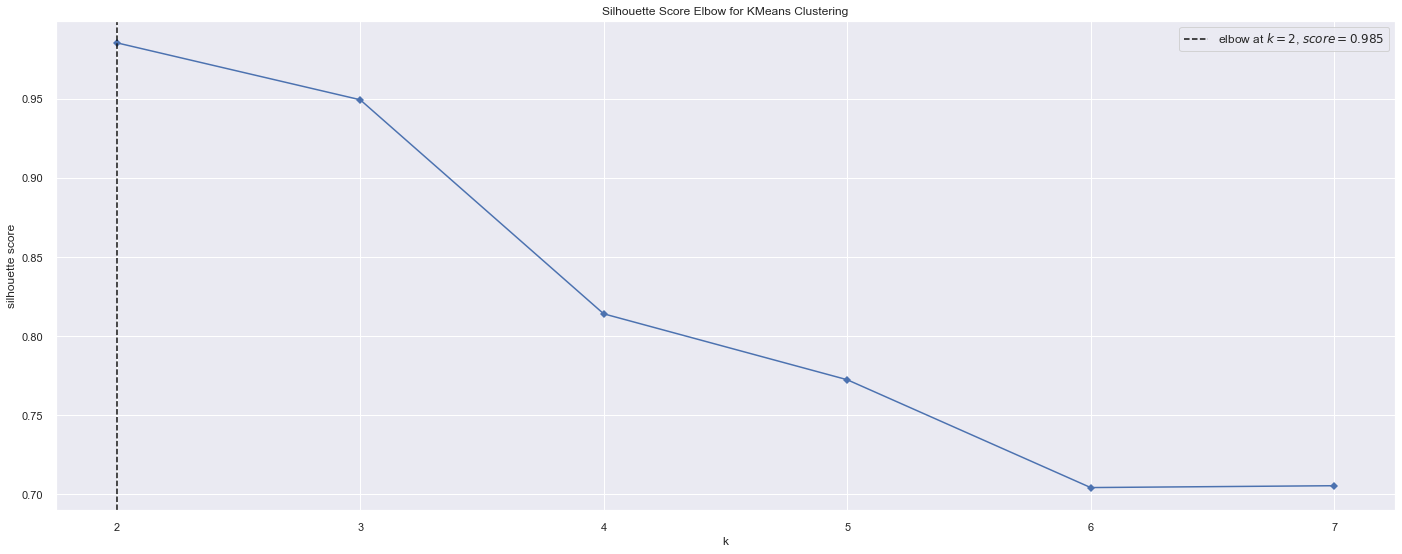

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [22]:
kmeans = yc.KElbowVisualizer( c.KMeans( init='random', n_init=10,
                                     max_iter=300, random_state=42 ), 
                           k=clusters, 
                           metric='silhouette', 
                           timings=False )
kmeans.fit( X )
kmeans.show()

# <font color='red'> 8.0. Model Training </font>

## 8.1. K-Means

In [23]:
# model definition
k = 3
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

### 8.1.1. Clustering Validation

In [401]:
# model performance 
## WSS ( Within-cluster Sum of Square )
print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# Average Silhouette -> Best value is 1, Worst value is -1, Overlap Clustering is 0
average_silhouette = m.silhouette_score( X, labels, metric='euclidean' )
print( 'AS value: {}'.format( average_silhouette ) )

WSS value: 41.63443878833437
AS value: 0.6451057541796843


# <font color='red'> 9.0. Cluster Analysis </font>

In [402]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,cluster
0,17850,0.809651,0.137652,0.033746,0.528258,2
1,13047,0.083110,0.068826,0.025960,0.528106,1
2,12583,0.005362,0.068826,0.040437,0.529691,1
3,13748,0.254692,0.016194,0.018451,0.530335,0
4,15100,0.884718,0.020243,0.017347,0.539168,2


## 9.1. Silhouette Analysis

In [403]:
X = df9.drop( columns=['customer_id', 'cluster'], axis=1 )
y = df9['cluster']

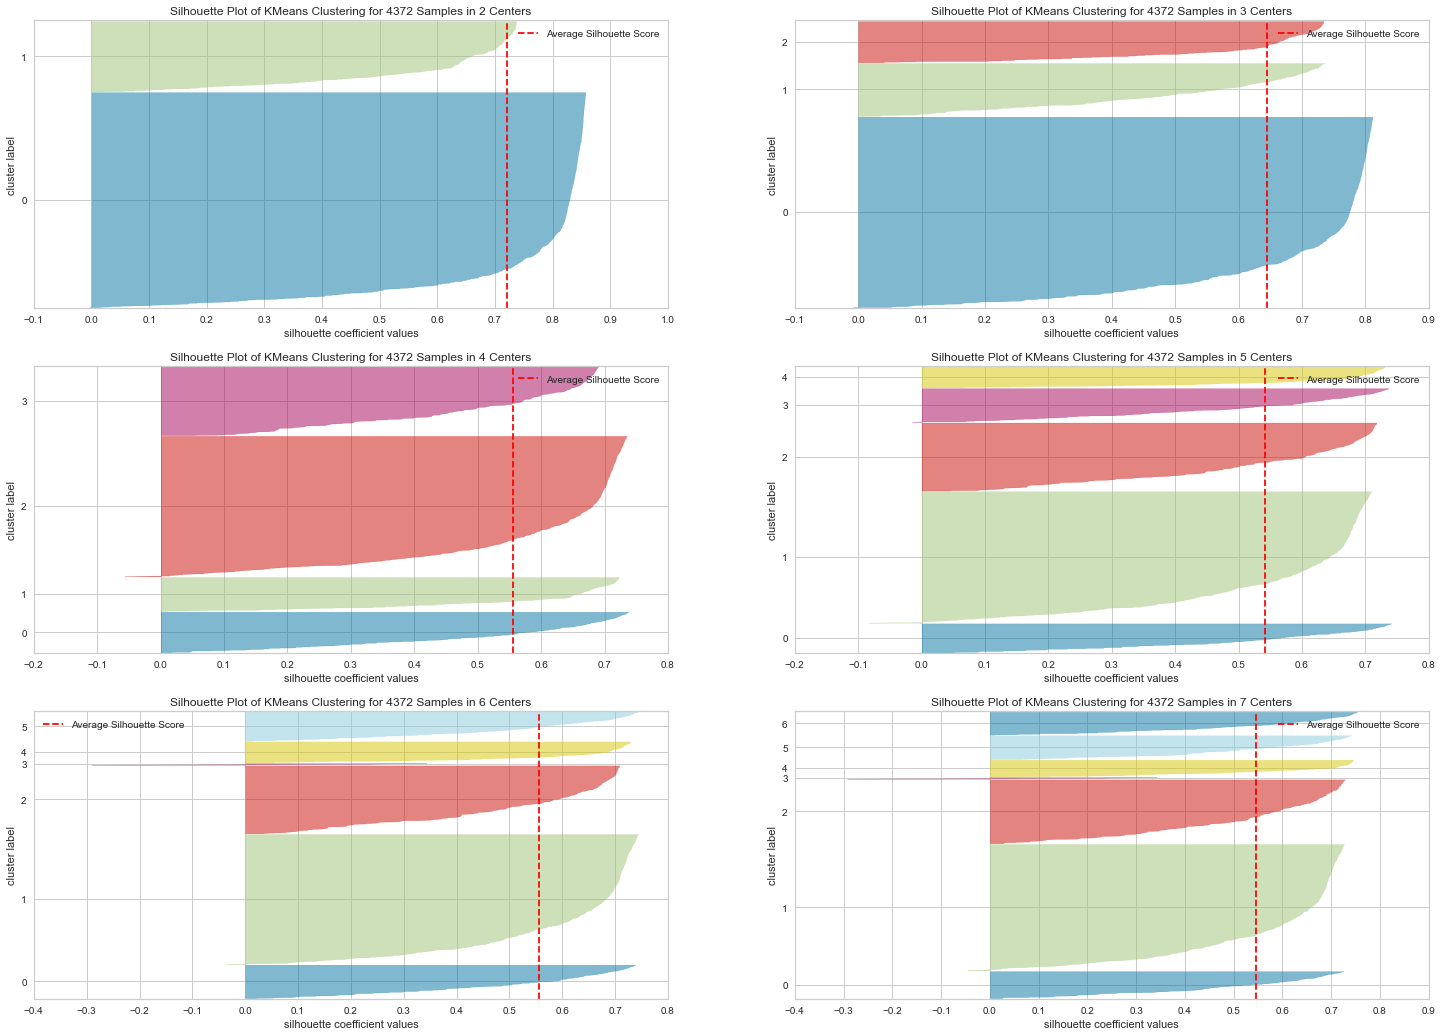

In [404]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(25,18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

## 9.1. Visual Inspection

### 9.1.1. 3d Plot

In [405]:
#sns.scatterplot( x='recency_days', y='gross_revenue', hue='cluster', data=df9 )

### 9.1.2. t-SNE

<AxesSubplot:xlabel='tsne-one', ylabel='tsne-two'>

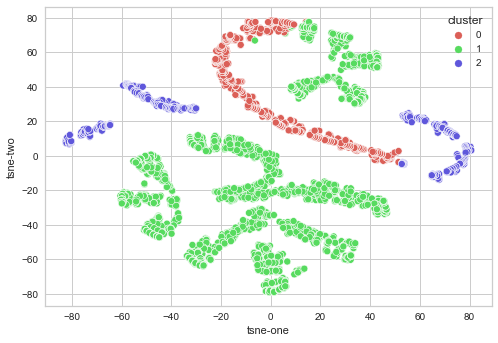

In [406]:
df_viz = df9.drop( columns=['customer_id', 'cluster'], axis=1 )

tsne = mf.TSNE( n_components=2, verbose=0 )
new_space = tsne.fit_transform( df_viz )


# get new space
df_viz['tsne-one'] = new_space[:,0]
df_viz['tsne-two'] = new_space[:,1]
df_viz['cluster'] = df9['cluster']

# plot t-SNE
sns.scatterplot( x='tsne-one', 
                 y='tsne-two', 
                 hue='cluster', 
                 palette=sns.color_palette('hls', n_colors=len( df_viz['cluster'].unique() ) ), 
                 data=df_viz )

## 9.2. Cluster Profile

In [407]:
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,cluster
0,17850,0.809651,0.137652,0.033746,0.528258,2
1,13047,0.083110,0.068826,0.025960,0.528106,1
2,12583,0.005362,0.068826,0.040437,0.529691,1
3,13748,0.254692,0.016194,0.018451,0.530335,0
4,15100,0.884718,0.020243,0.017347,0.539168,2


In [408]:
# Number of customer
df_cluster = df9[['cluster', 'customer_id']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Recency
df_avg_recency = df9[['cluster', 'recency_days']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency, how='inner', on='cluster' )

## Avg Invoice Number
#df_avg_invoice = df9[['cluster', 'invoice_no']].groupby( 'cluster' ).mean().reset_index()
#df_cluster = pd.merge( df_cluster, df_avg_invoice, how='inner', on='cluster' )

# Avg Gross Revenue
df_avg_gross_revenue = df9[['cluster', 'gross_revenue']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,recency_days,gross_revenue
1,1,2925,66.903019,0.082126,0.024109
0,0,813,18.595608,0.408318,0.017594
2,2,634,14.501372,0.790627,0.016536


## Cluster 01:  ( Candidato à Insider )
    - Número de customers: 6 (14% do customers )
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
## Cluster 02: 
    - Número de customers: 31 (71% do customers )
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52 dólares
        
## Cluster 03: 
    - Número de customers: 4.335 (99% do customers )
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57 dólares
        

# <font color='red'> 10.0. Deploy to Production </font>

# <font color='red'> 11.0. Sand box </font>

## 11.1. Original dataset  </font>

In [25]:
from sklearn import cluster as c

from sklearn.datasets import make_blobs
from yellowbrick.cluster import SilhouetteVisualizer,KElbowVisualizer
from matplotlib import pyplot as plt

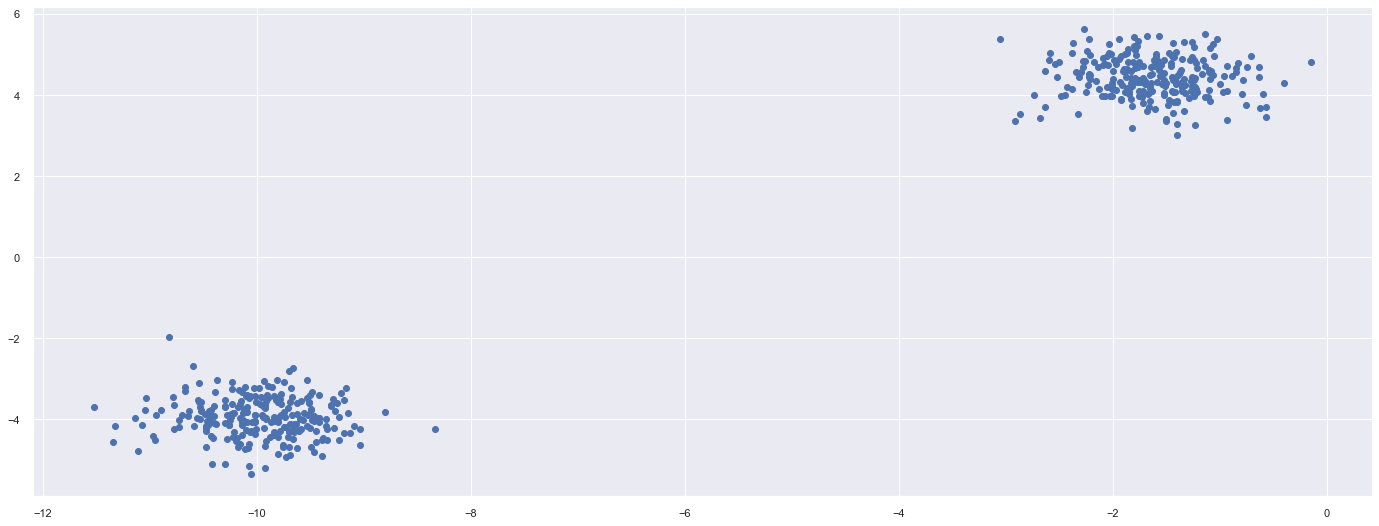

In [32]:
# dataset
X, y = make_blobs( n_samples=500, n_features=2,
                   centers=2,
                   cluster_std=0.5,
                   center_box=(-10.0, 10.0),
                   shuffle=True,
                   random_state=1 )
# plot dataset  
plt.scatter( X[:,0], X[:,1] )

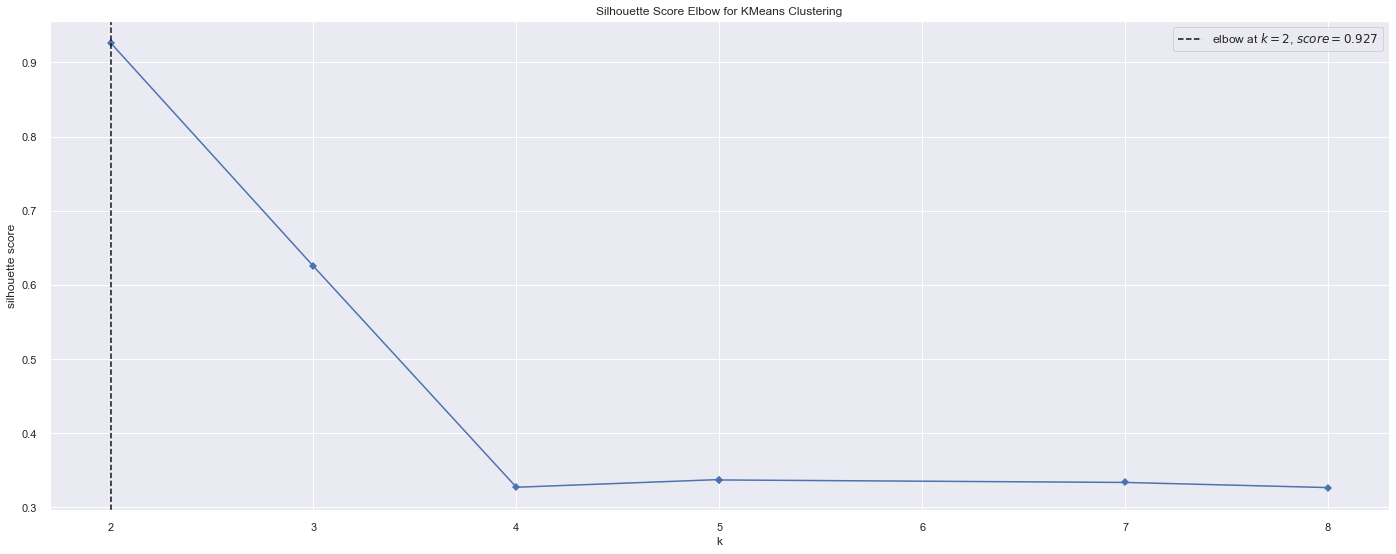

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [33]:
# modeling
clusters = [ 2, 3, 4, 5, 5, 7, 8]

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show()

## 11.2. Silhouette Analysis  </font>

IndexError: index 2 is out of bounds for axis 0 with size 2

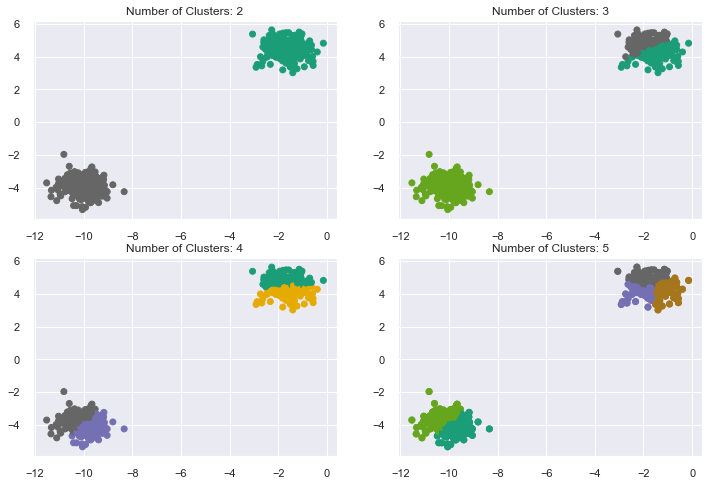

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
for i in clusters:
    kmeans = c.KMeans( n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42 )
    kmeans.fit( X )
    
    q, mod = divmod( i, 2)
    ax[q-1, mod].scatter( X[:, 0], X[:, 1], c=kmeans.labels_, cmap=plt.cm.Dark2 )
    ax[q-1, mod].set_title( 'Number of Clusters: {}'.format( i ) )

IndexError: index 2 is out of bounds for axis 0 with size 2

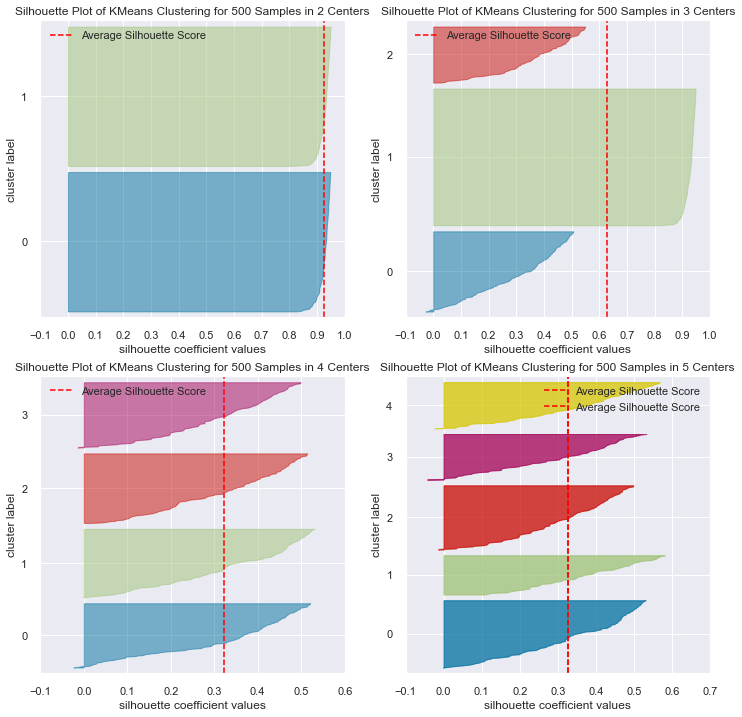

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
for i in clusters:
    kmeans = c.KMeans( n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( i, 2 )
    
    visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()